# Train a ready to use PyTorch model with a simple pipeline

In [1]:
import sys

# the following line is not required if BatchFlow is installed as a python package.
sys.path.append("../..")
from batchflow import Pipeline, B, C, D, F, V
from batchflow.opensets import MNIST, CIFAR10, CIFAR100
from batchflow.models.torch import VGG7
from batchflow.utils import plot_loss

BATCH_SIZE might be increased for modern GPUs with lots of memory (4GB and higher).

In [2]:
BATCH_SIZE = 64

# Create a dataset

[MNIST](http://yann.lecun.com/exdb/mnist/) is a dataset of handwritten digits frequently used as a baseline for machine learning tasks.

Downloading MNIST database might take a few minutes to complete.   
In your experiments you can use [Imagenette](https://analysiscenter.github.io/batchflow/api/batchflow.opensets.html#imagenette) and [CIFAR](https://analysiscenter.github.io/batchflow/api/batchflow.opensets.html#cifar100) datasets as well.

In [3]:
dataset = MNIST(bar=True)

100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


There are also predefined CIFAR10 and CIFAR100 datasets.

# Define a pipeline config

Config allows to create flexible pipelines which take parameters.

For instance, if you put a model type into config, you can run a pipeline against different models.

See [a list of available models](https://analysiscenter.github.io/batchflow/intro/torch_models.html#ready-to-use-models) to choose the one which fits you best.

In [4]:
config = dict(model=VGG7)

# Create a template pipeline

A template pipeline is not linked to any dataset. It's just an abstract sequence of actions, so it cannot be executed, but it serves as a convenient building block.

In [5]:
%env CUDA_VISIBLE_DEVICES=5
train_template = (Pipeline()
                .init_variable('loss_history', [])
                .init_model('dynamic', C('model'), 'conv_nn',
                            config={'inputs/images/shape': B.image_shape,
                                    'inputs/labels/classes': D.num_classes,
                                    'initial_block/inputs': 'images',
                                    'device': 'gpu'})
                .to_array(channels='first', dtype='float32')
                .train_model('conv_nn', B.images, B.labels,
                             fetches='loss', save_to=V('loss_history', mode='a'), use_lock=True)
)

env: CUDA_VISIBLE_DEVICES=5


# Train the model

Apply a dataset and a config to a template pipeline to create a runnable pipeline:

In [6]:
train_pipeline = (train_template << dataset.train) << config

Run the pipeline (it might take from a few minutes to a few hours depending on your hardware)

In [7]:
train_pipeline.run(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=True, bar=True, prefetch=1)

100%|██████████| 937/937 [00:48<00:00, 19.18it/s]


Note that the progress bar often increments by 2 at a time - that's prefetch in action.

It does not give much here, though, since almost all time is spent in model training which is performed under a thread-lock one batch after another without any parallelism (otherwise the model would not learn anything as different batches would rewrite one another's model weights updates).

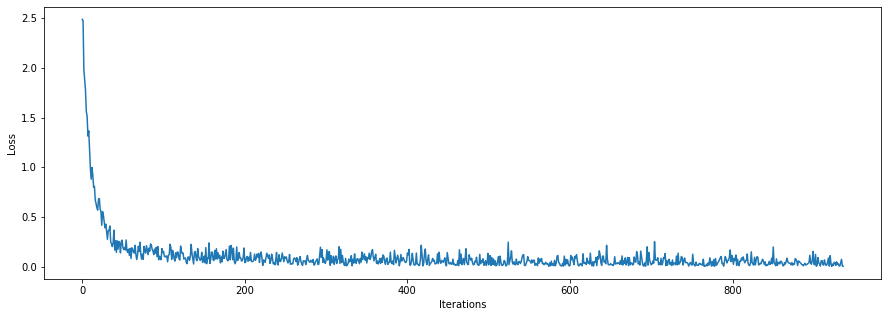

In [8]:
loss = train_pipeline.v('loss_history')
plot_loss(loss)

# Test the model

It is much faster than training, but if you don't have GPU it would take some patience.

In [9]:
test_pipeline = (dataset.test.p
                .import_model('conv_nn', train_pipeline)
                .init_variable('predictions') 
                .init_variable('metrics') 
                .to_array(channels='first', dtype='float32')
                .predict_model('conv_nn', B.images,
                               fetches='predictions', save_to=V('predictions'))
                .gather_metrics('class', targets=B.labels, predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics', mode='a'))
                .run(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

100%|██████████| 157/157 [00:04<00:00, 35.67it/s]


Let's get the accumulated [metrics information](https://analysiscenter.github.io/batchflow/intro/models.html#model-metrics)

In [10]:
metrics = test_pipeline.get_variable('metrics')

Or a shorter version: `metrics = test_pipeline.v('metrics')`

Now we can easiliy calculate any metrics we need

In [11]:
metrics.evaluate('accuracy')

0.9920382165605095

In [12]:
metrics.evaluate(['false_positive_rate', 'false_negative_rate'], multiclass=None)

{'false_positive_rate': array([0.00022777, 0.00103437, 0.00187466, 0.00145135, 0.0002217 ,
        0.00097707, 0.00043201, 0.00066224, 0.00154444, 0.00043555]),
 'false_negative_rate': array([0.00677154, 0.00374   , 0.00106157, 0.00079618, 0.01195026,
        0.0167703 , 0.00933172, 0.00758771, 0.0026792 , 0.02213927])}

# Save the model
After learning the model, you may need to save it. It's easy to do this.

In [ ]:
train_pipeline.save_model_now('conv_nn', path='path/to/model.torch')

## What's next?

See [the image augmentation tutorial](./06_image_augmentation.ipynb) or return to the [table of contents](./00_description.ipynb).